# Fiat Debasement & Wealth Allocation — Exploratory Data Analysis

This notebook loads the processed analysis dataframe and explores three questions:
1. How have real returns of BTC, gold, equities and USD cash evolved over time?
2. Do debasement conditions visually co-move with asset return spreads?
3. Does the PCA-derived debasement score align with the z-score composite, and what do the PCA loadings reveal?

## 0. Imports & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plot aesthetics
plt.rcParams.update({
    "figure.dpi":        130,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.grid":         True,
    "grid.alpha":        0.3,
    "font.size":         11,
})

PROCESSED_DATA_DIR = "processed_data"
FIGURES_DIR        = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# Debasement indicator columns used across multiple sections
DEBASEMENT_INDICATOR_COLUMNS = [
    "m2_yoy_pct",
    "cpi_yoy_pct",
    "real_m2_growth",
    "m2_to_gdp",
]

DEBASEMENT_LABELS = {
    "m2_yoy_pct":     "M2 YoY Growth (%)",
    "cpi_yoy_pct":    "CPI YoY Inflation (%)",
    "real_m2_growth": "Real M2 Growth (M2 - CPI)",
    "m2_to_gdp":      "M2 / GDP Ratio",
}

ASSET_COLORS = {
    "btc":   "#F7931A",
    "gold":  "#C9A84C",
    "sp500": "#4C72B0",
    "cash":  "#55A868",
}

## 1. Load Data

In [2]:
analysis_df = pd.read_csv(
    os.path.join(PROCESSED_DATA_DIR, "analysis_df.csv"),
    index_col=0,
    parse_dates=True
)

analysis_df.index.name = "date"

print(f"Shape: {analysis_df.shape}")
print(f"Date range: {analysis_df.index.min().date()} → {analysis_df.index.max().date()}")
print(f"\nColumns:\n{list(analysis_df.columns)}")
analysis_df.head()

Shape: (119, 18)
Date range: 2015-09-30 → 2025-07-31

Columns:
['fed_funds_rate', 'tips_real_yield_10y', 'm2_yoy_pct', 'cpi_yoy_pct', 'real_m2_growth', 'm2_to_gdp', 'btc_return_monthly', 'sp500_return_monthly', 'gold_return_monthly', 'cash_real_return_monthly', 'btc_vs_cash_real_spread', 'gold_vs_cash_real_spread', 'sp500_vs_cash_real_spread', 'z_m2_yoy_pct', 'z_cpi_yoy_pct', 'z_real_m2_growth', 'z_m2_to_gdp', 'zscore_composite_debasement_score']


,fed_funds_rate,tips_real_yield_10y,m2_yoy_pct,cpi_yoy_pct,real_m2_growth,m2_to_gdp,btc_return_monthly,sp500_return_monthly,gold_return_monthly,cash_real_return_monthly,btc_vs_cash_real_spread,gold_vs_cash_real_spread,sp500_vs_cash_real_spread,z_m2_yoy_pct,z_cpi_yoy_pct,z_real_m2_growth,z_m2_to_gdp,zscore_composite_debasement_score
date,,,,,,,,,,,,,,,,,,
2015-09-30,0.07,0.65,5.663838,0.008843,5.654995,0.659663,0.025763,-0.026799,-0.014330,0.000051,0.025712,-0.014381,-0.026850,-0.112658,-1.408998,0.289202,-1.035152,-0.566902
2015-10-31,0.07,0.63,5.433374,0.127617,5.305758,0.662083,0.285835,0.079719,0.023040,-0.000048,0.285883,0.023088,0.079767,-0.145207,-1.354082,0.244308,-1.000753,-0.563934
2015-11-30,0.08,0.62,5.849896,0.436318,5.413578,0.666361,0.183175,0.000505,-0.068617,-0.000297,0.183472,-0.068321,0.000802,-0.086380,-1.211352,0.258168,-0.939963,-0.494882
2015-12-31,0.20,0.73,5.702077,0.638725,5.063352,0.669176,0.132007,-0.017686,-0.005174,-0.000366,0.132372,-0.004808,-0.017320,-0.107257,-1.117767,0.213147,-0.899949,-0.477957
2016-01-31,0.29,0.53,6.088498,1.237503,4.850996,0.675027,-0.154938,-0.052068,0.051557,-0.000790,-0.154148,0.052347,-0.051278,-0.052682,-0.840918,0.185849,-0.816792,-0.381136


In [3]:
# Quick descriptive statistics
analysis_df.describe().round(4)

,fed_funds_rate,tips_real_yield_10y,m2_yoy_pct,cpi_yoy_pct,real_m2_growth,m2_to_gdp,btc_return_monthly,sp500_return_monthly,gold_return_monthly,cash_real_return_monthly,btc_vs_cash_real_spread,gold_vs_cash_real_spread,sp500_vs_cash_real_spread,z_m2_yoy_pct,z_cpi_yoy_pct,z_real_m2_growth,z_m2_to_gdp,zscore_composite_debasement_score
count,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000,119.0000
mean,2.0402,0.5813,6.4615,3.0563,3.4052,0.7406,0.0523,0.0098,0.0090,-0.0008,0.0531,0.0098,0.0107,-0.0000,0.0000,0.0000,0.1159,0.0290
std,1.9349,0.9830,7.0805,2.1628,7.7792,0.0687,0.1988,0.0445,0.0384,0.0022,0.1984,0.0381,0.0442,1.0000,1.0000,1.0000,0.9765,0.6909
min,0.0500,-1.1600,-4.6910,0.0088,-9.6411,0.6597,-0.4743,-0.1337,-0.0825,-0.0069,-0.4681,-0.0814,-0.1325,-1.5751,-1.4090,-1.6771,-1.0352,-0.6682
25%,0.2900,0.0050,3.4487,1.6844,0.2933,0.6843,-0.0741,-0.0128,-0.0178,-0.0012,-0.0740,-0.0153,-0.0137,-0.4255,-0.6343,-0.4000,-0.6848,-0.4123
50%,1.5800,0.5300,5.2185,2.4265,2.7197,0.7144,0.0533,0.0177,0.0049,-0.0006,0.0589,0.0058,0.0173,-0.1755,-0.2912,-0.0881,-0.2567,-0.3080
75%,4.3300,1.4750,7.1551,3.3384,5.3597,0.8043,0.1777,0.0353,0.0324,0.0006,0.1800,0.0350,0.0368,0.0980,0.1304,0.2512,1.0210,0.3724
max,5.3300,2.4600,26.7021,8.9794,25.0322,0.8802,0.5284,0.1194,0.1001,0.0023,0.5293,0.1005,0.1196,2.8586,2.7386,2.7801,2.0999,1.6794


## 2. Raw Debasement Indicators Over Time

Plot each indicator individually to understand their behaviour before compositing.

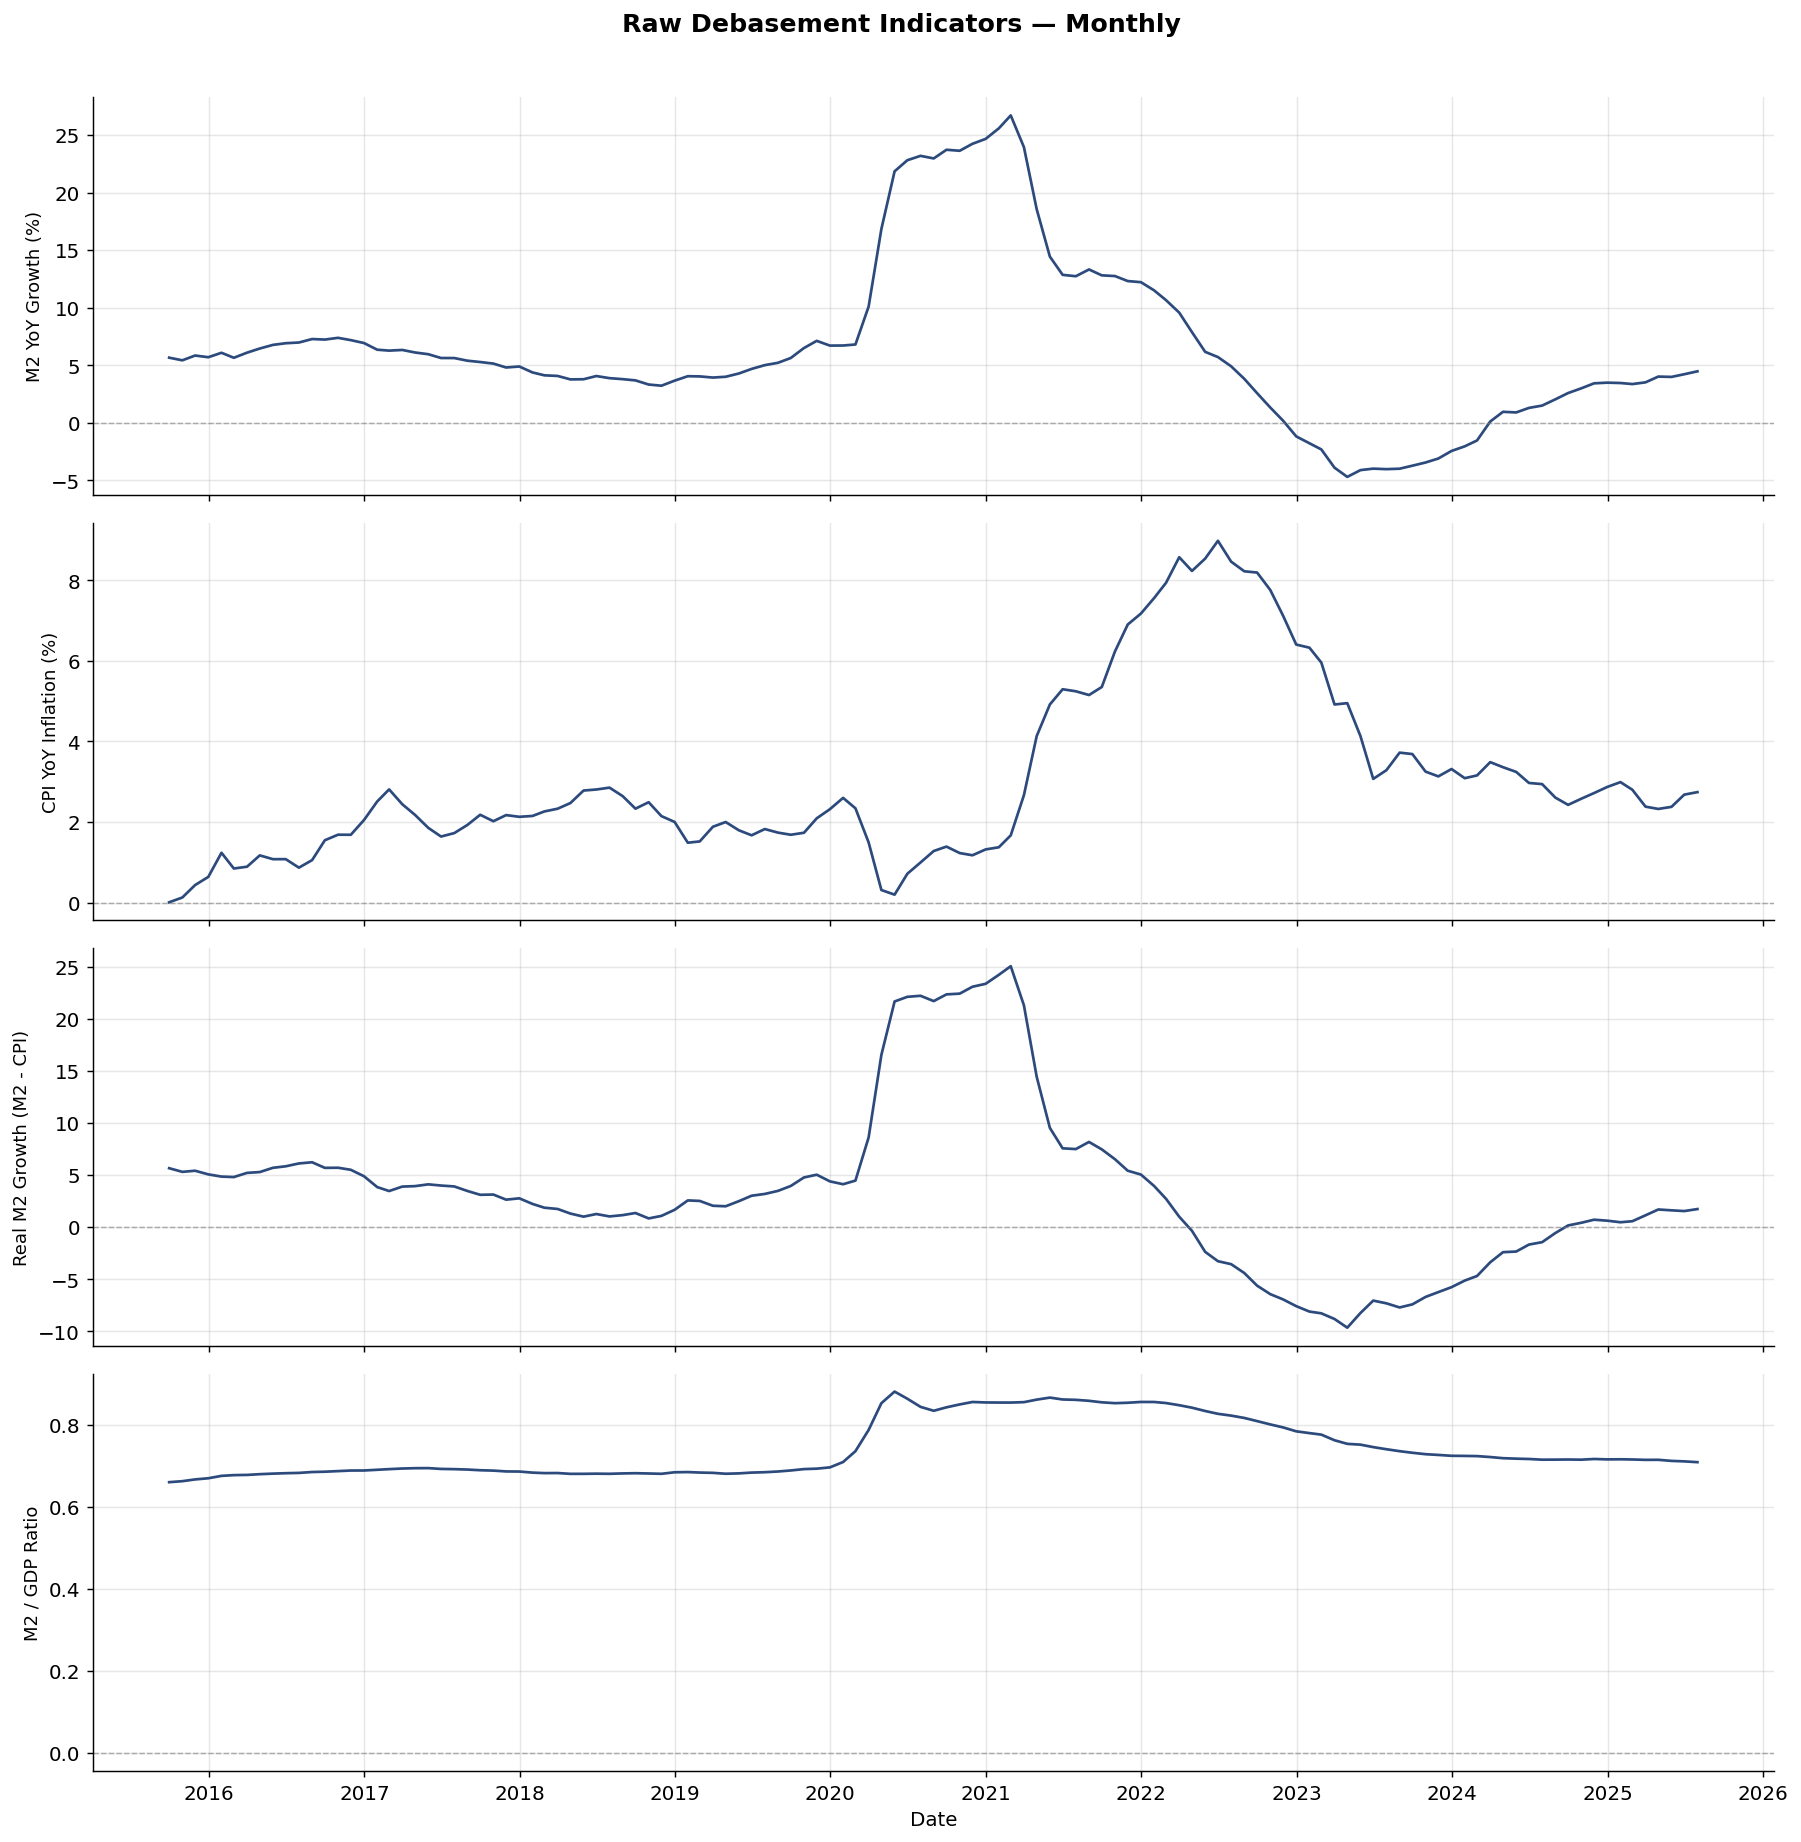

In [4]:
figure, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
figure.suptitle("Raw Debasement Indicators — Monthly", fontsize=14, fontweight="bold", y=1.01)

for axis, column_name in zip(axes, DEBASEMENT_INDICATOR_COLUMNS):
    axis.plot(analysis_df.index, analysis_df[column_name], linewidth=1.5, color="#2C4A7C")
    axis.axhline(0, color="grey", linestyle="--", linewidth=0.8, alpha=0.6)
    axis.set_ylabel(DEBASEMENT_LABELS[column_name], fontsize=10)
    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "debasement_indicators_raw.png"), bbox_inches="tight")
plt.show()

## 3. Cumulative Real Returns — BTC vs Gold vs S&P 500 vs Cash

Starting from the first common observation, what does $1 in each asset grow to in real terms?

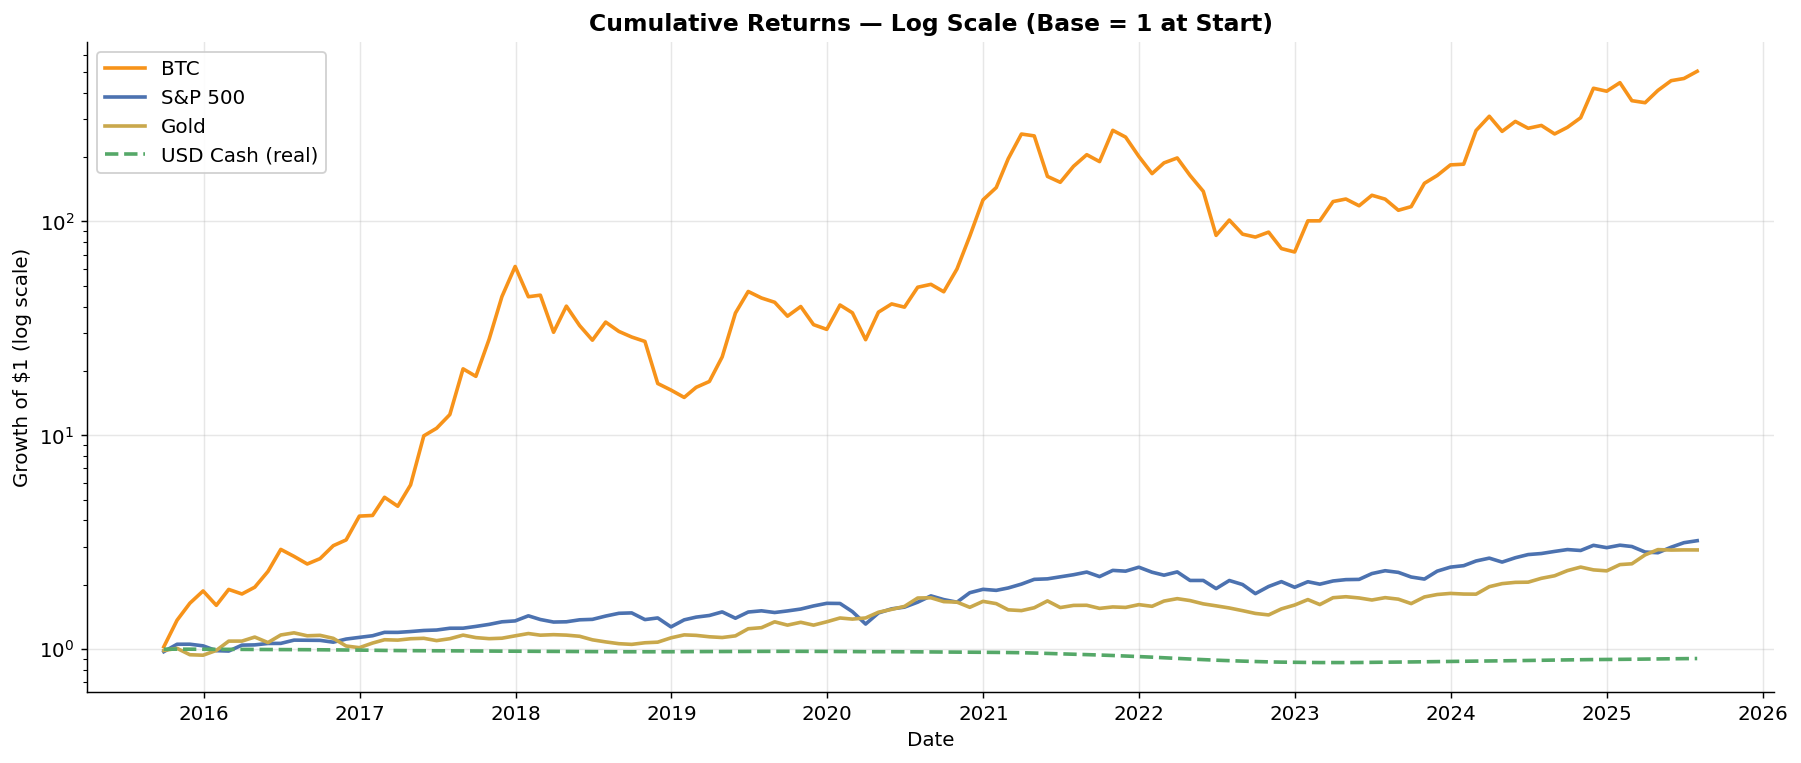

In [19]:
# Compute cumulative returns from log returns — exp(cumsum) recovers the growth factor
cumulative_btc   = np.exp(analysis_df["btc_return_monthly"].cumsum())
cumulative_sp500 = np.exp(analysis_df["sp500_return_monthly"].cumsum())
cumulative_gold  = np.exp(analysis_df["gold_return_monthly"].cumsum())

# Cash real return is already in rate form — cumulate additively then convert
cumulative_cash  = np.exp(analysis_df["cash_real_return_monthly"].cumsum())

figure, axis = plt.subplots(figsize=(14, 6))

axis.plot(analysis_df.index, cumulative_btc,   label="BTC",   color=ASSET_COLORS["btc"],   linewidth=2)
axis.plot(analysis_df.index, cumulative_sp500, label="S&P 500", color=ASSET_COLORS["sp500"], linewidth=2)
axis.plot(analysis_df.index, cumulative_gold,  label="Gold",  color=ASSET_COLORS["gold"],  linewidth=2)
axis.plot(analysis_df.index, cumulative_cash,  label="USD Cash (real)", color=ASSET_COLORS["cash"], linewidth=2, linestyle="--")

axis.set_yscale("log")
axis.set_title("Cumulative Returns — Log Scale (Base = 1 at Start)", fontsize=13, fontweight="bold")
axis.set_ylabel("Growth of $1 (log scale)")
axis.set_xlabel("Date")
axis.legend(framealpha=0.9)
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cumulative_returns_comparison.png"), bbox_inches="tight")
plt.show()

## 4. Real Return Spreads Over Time

Monthly excess return of each asset over real USD cash — positive = beat holding cash.

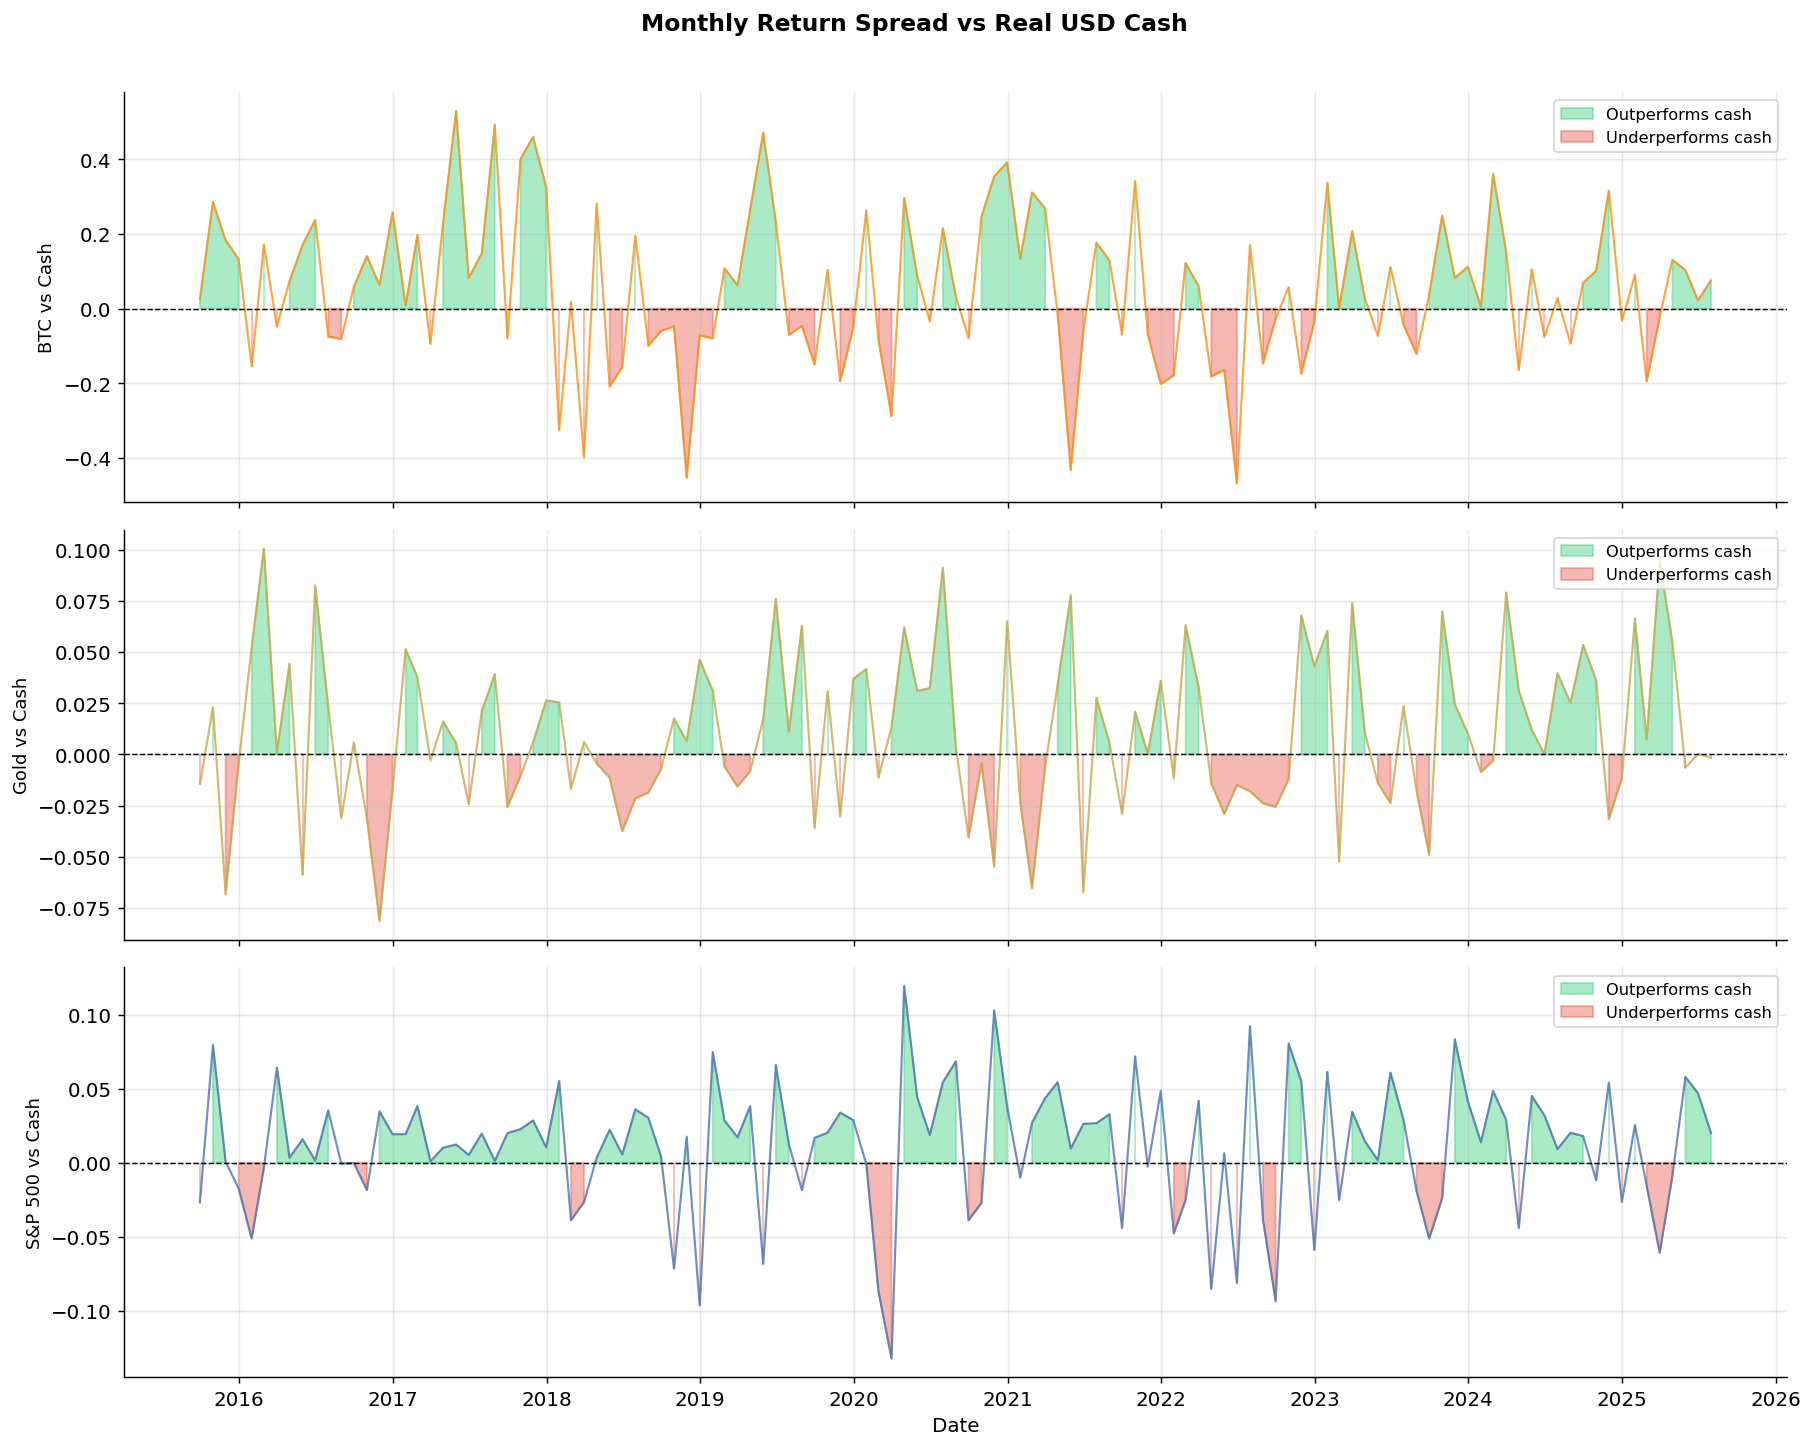

In [6]:
figure, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)
figure.suptitle("Monthly Return Spread vs Real USD Cash", fontsize=13, fontweight="bold", y=1.01)

spread_configs = [
    ("btc_vs_cash_real_spread",   "BTC vs Cash",    ASSET_COLORS["btc"]),
    ("gold_vs_cash_real_spread",  "Gold vs Cash",   ASSET_COLORS["gold"]),
    ("sp500_vs_cash_real_spread", "S&P 500 vs Cash", ASSET_COLORS["sp500"]),
]

for axis, (column_name, label, color) in zip(axes, spread_configs):
    # Fill positive spread green, negative red for visual clarity
    axis.fill_between(
        analysis_df.index,
        analysis_df[column_name],
        0,
        where=analysis_df[column_name] >= 0,
        alpha=0.4,
        color="#2ECC71",
        label="Outperforms cash"
    )
    axis.fill_between(
        analysis_df.index,
        analysis_df[column_name],
        0,
        where=analysis_df[column_name] < 0,
        alpha=0.4,
        color="#E74C3C",
        label="Underperforms cash"
    )
    axis.plot(analysis_df.index, analysis_df[column_name], color=color, linewidth=1.2, alpha=0.8)
    axis.axhline(0, color="black", linewidth=0.8, linestyle="--")
    axis.set_ylabel(label, fontsize=10)
    axis.legend(fontsize=9, loc="upper right")
    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "return_spreads_vs_cash.png"), bbox_inches="tight")
plt.show()

## 5. Debasement Score vs Asset Spreads — Visual Co-movement

Overlay the z-score composite debasement score with each asset's rolling 12-month mean spread to check for co-movement.

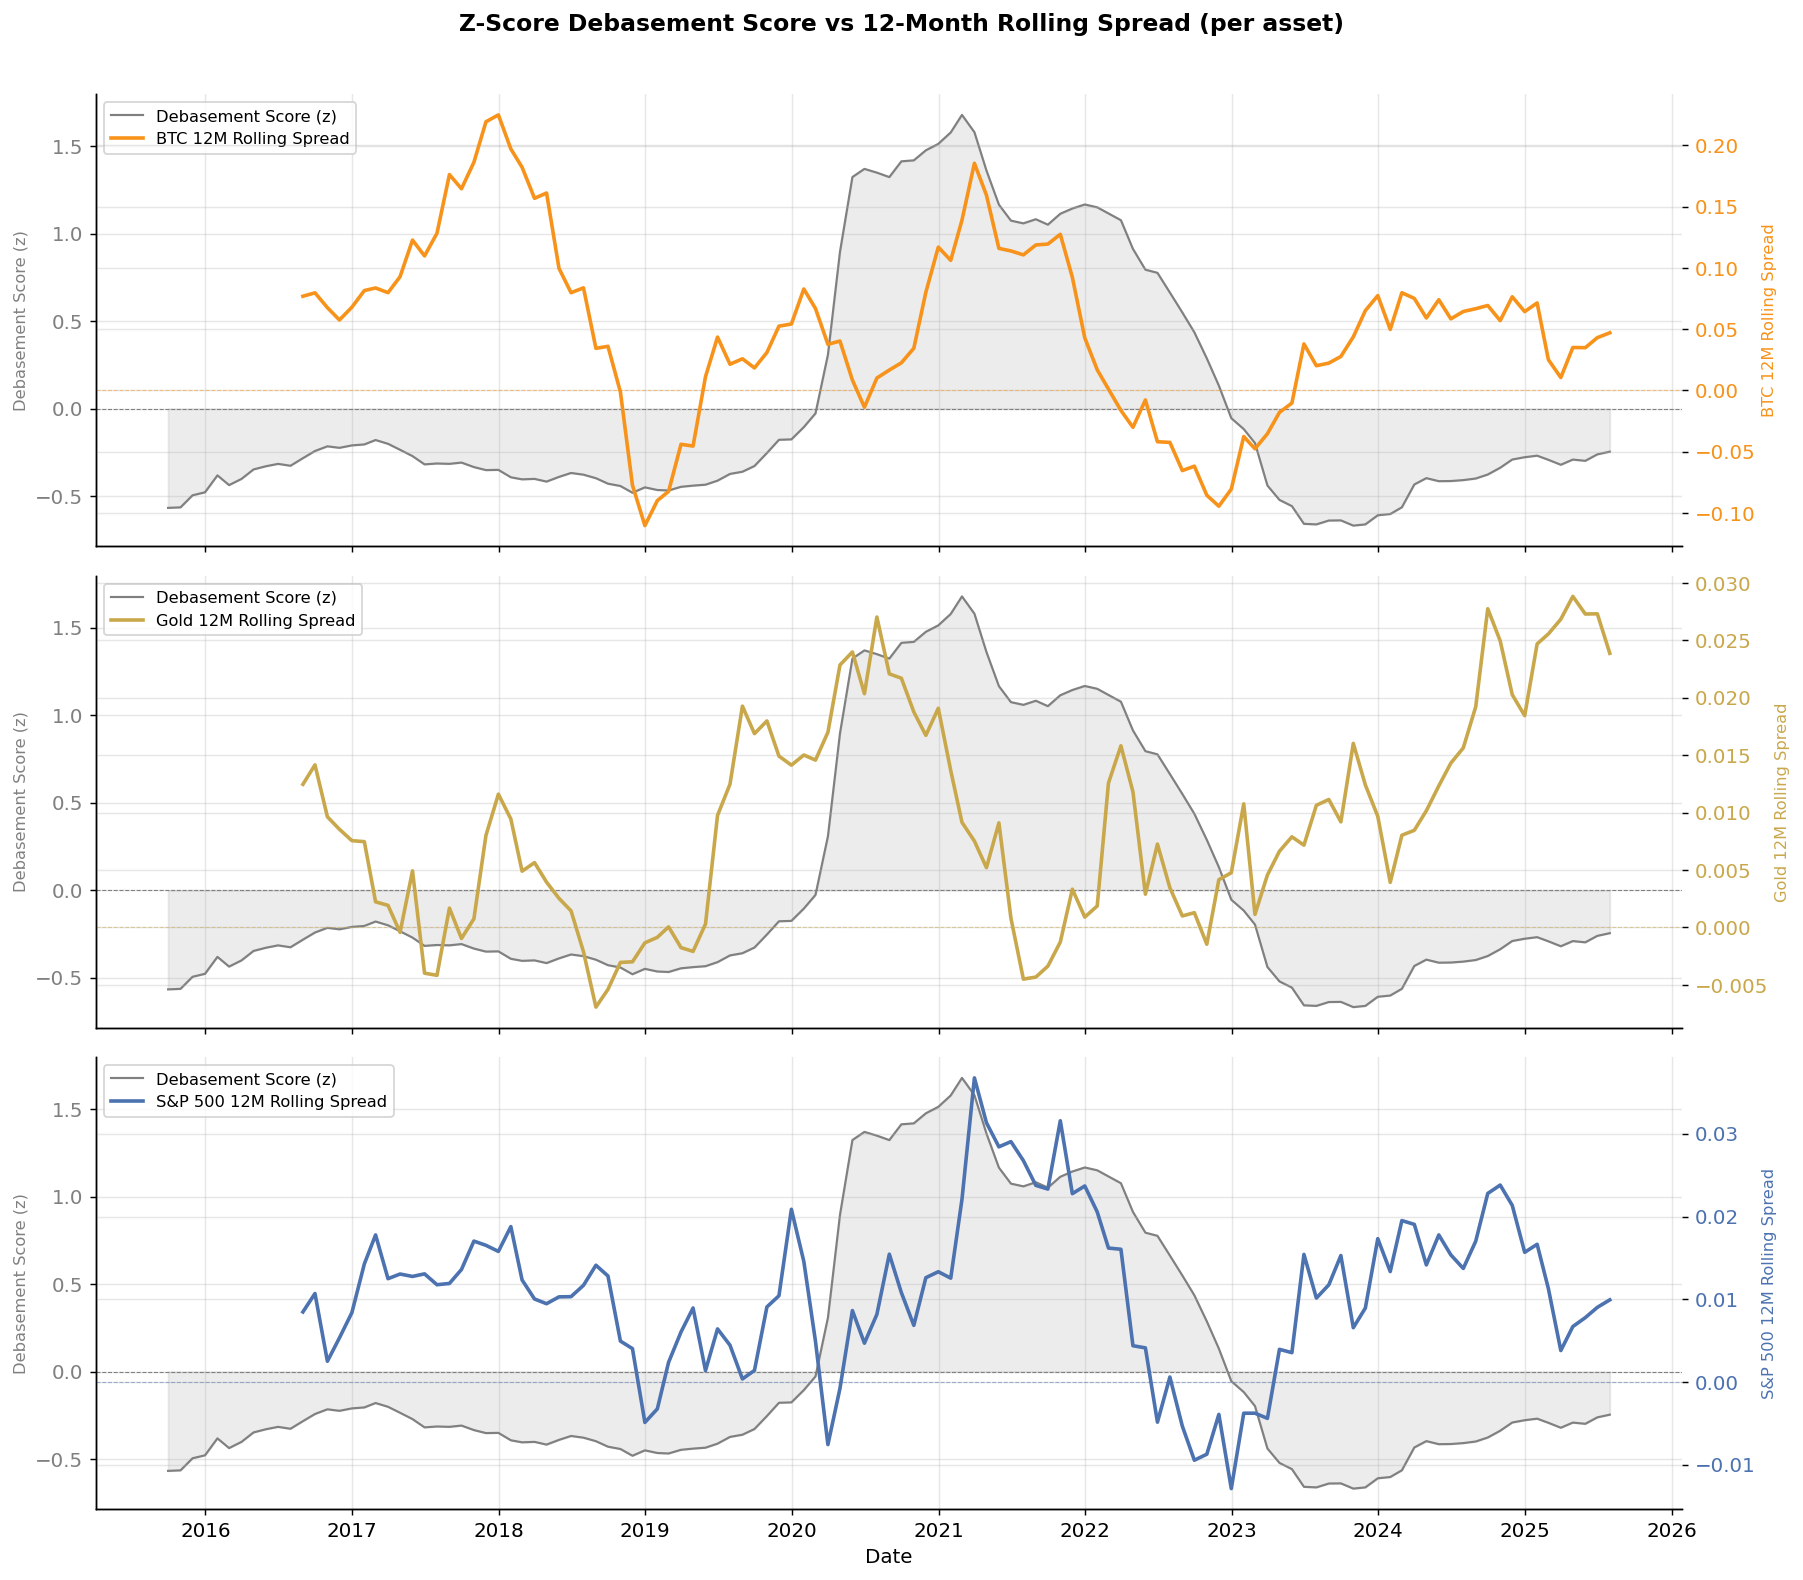

In [7]:
# Rolling 12-month mean of each spread to smooth monthly noise
rolling_window = 12
btc_rolling_spread   = analysis_df["btc_vs_cash_real_spread"].rolling(rolling_window).mean()
gold_rolling_spread  = analysis_df["gold_vs_cash_real_spread"].rolling(rolling_window).mean()
sp500_rolling_spread = analysis_df["sp500_vs_cash_real_spread"].rolling(rolling_window).mean()
debasement_score     = analysis_df["zscore_composite_debasement_score"]

figure, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
figure.suptitle(
    f"Z-Score Debasement Score vs {rolling_window}-Month Rolling Spread (per asset)",
    fontsize=13, fontweight="bold", y=1.01
)

rolling_spread_configs = [
    (btc_rolling_spread,   "BTC 12M Rolling Spread",    ASSET_COLORS["btc"]),
    (gold_rolling_spread,  "Gold 12M Rolling Spread",   ASSET_COLORS["gold"]),
    (sp500_rolling_spread, "S&P 500 12M Rolling Spread", ASSET_COLORS["sp500"]),
]

for axis, (rolling_spread, label, color) in zip(axes, rolling_spread_configs):
    twin_axis = axis.twinx()

    # Debasement score on primary axis
    axis.fill_between(analysis_df.index, debasement_score, 0, alpha=0.15, color="grey")
    axis.plot(analysis_df.index, debasement_score, color="grey", linewidth=1.2, label="Debasement Score (z)")
    axis.axhline(0, color="grey", linestyle="--", linewidth=0.6)
    axis.set_ylabel("Debasement Score (z)", color="grey", fontsize=9)
    axis.tick_params(axis="y", labelcolor="grey")

    # Rolling spread on secondary axis
    twin_axis.plot(analysis_df.index, rolling_spread, color=color, linewidth=2, label=label)
    twin_axis.axhline(0, color=color, linestyle="--", linewidth=0.6, alpha=0.5)
    twin_axis.set_ylabel(label, color=color, fontsize=9)
    twin_axis.tick_params(axis="y", labelcolor=color)

    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Combined legend
    lines_primary, labels_primary     = axis.get_legend_handles_labels()
    lines_secondary, labels_secondary = twin_axis.get_legend_handles_labels()
    axis.legend(lines_primary + lines_secondary, labels_primary + labels_secondary, fontsize=9, loc="upper left")

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "debasement_score_vs_spreads.png"), bbox_inches="tight")
plt.show()

## 6. Real Rates Over Time

The transmission mechanism — when real rates are deeply negative, opportunity cost of leaving hard assets is high.

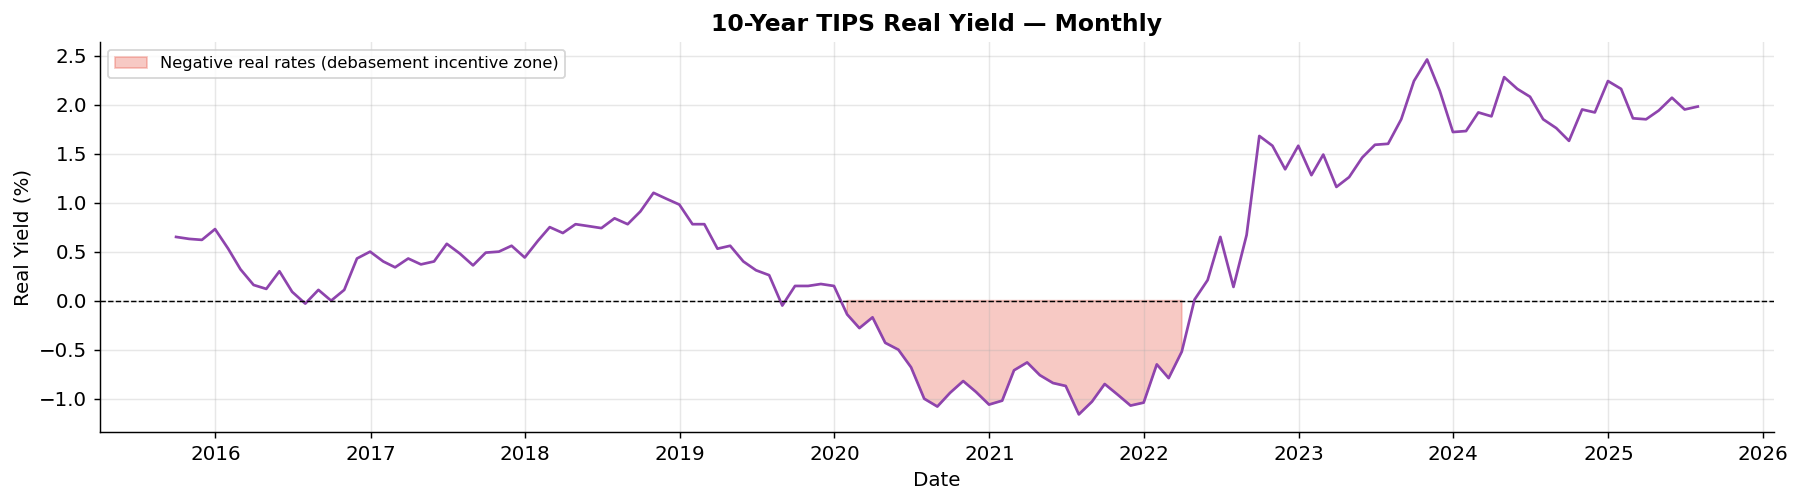

In [8]:
figure, axis = plt.subplots(figsize=(14, 4))

axis.plot(analysis_df.index, analysis_df["tips_real_yield_10y"], color="#8E44AD", linewidth=1.5)
axis.fill_between(
    analysis_df.index,
    analysis_df["tips_real_yield_10y"],
    0,
    where=analysis_df["tips_real_yield_10y"] < 0,
    alpha=0.3,
    color="#E74C3C",
    label="Negative real rates (debasement incentive zone)"
)
axis.axhline(0, color="black", linewidth=0.8, linestyle="--")
axis.set_title("10-Year TIPS Real Yield — Monthly", fontsize=13, fontweight="bold")
axis.set_ylabel("Real Yield (%)")
axis.set_xlabel("Date")
axis.legend(fontsize=9)
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "real_rates_tips.png"), bbox_inches="tight")
plt.show()

## 7. Correlation Matrix

Full pairwise correlation across all features to understand relationships before modelling.

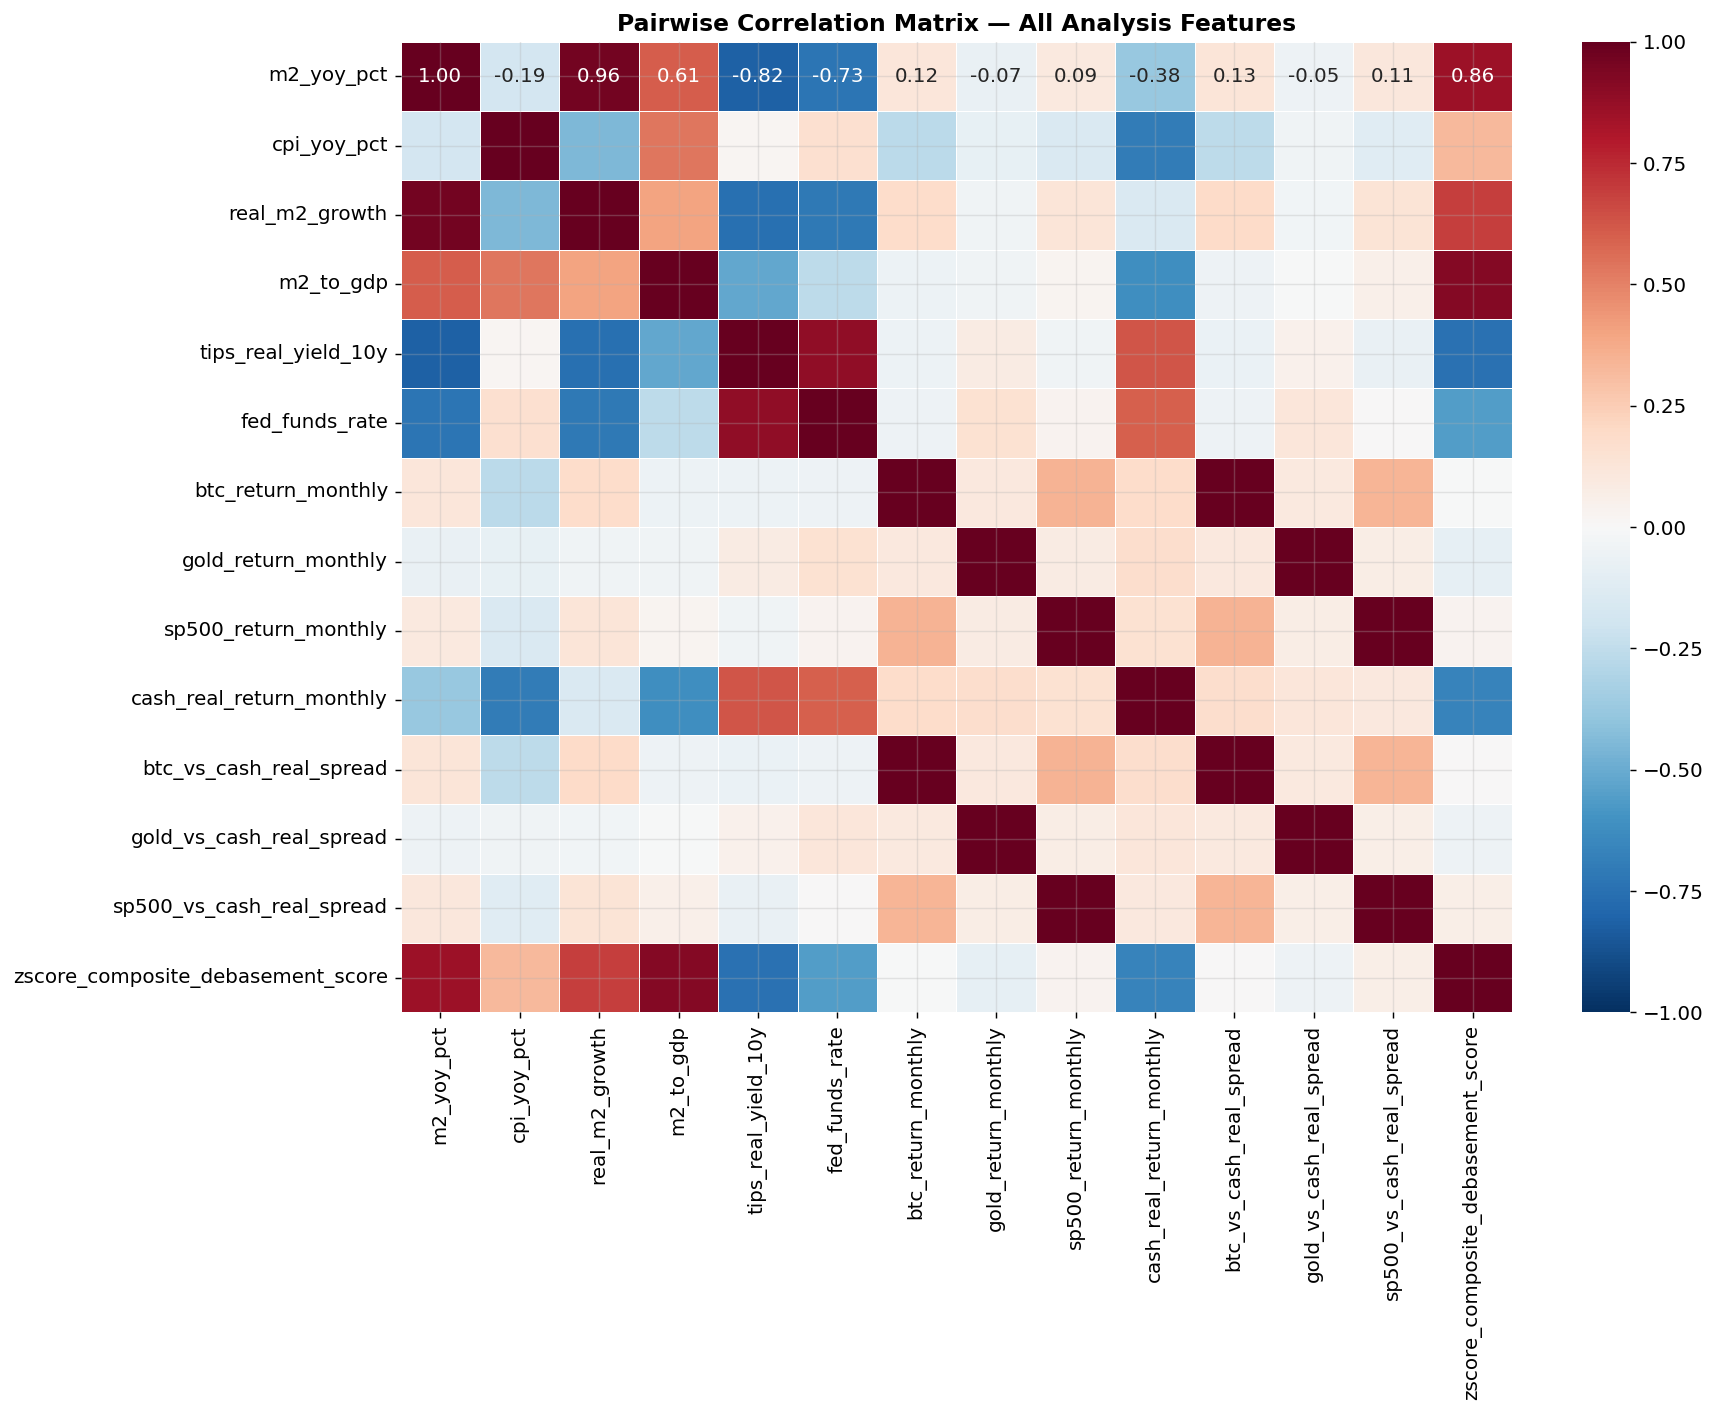

In [9]:
# Select analysis-relevant columns — exclude z_ duplicates to avoid redundancy
correlation_columns = [
    "m2_yoy_pct", "cpi_yoy_pct", "real_m2_growth", "m2_to_gdp",
    "tips_real_yield_10y", "fed_funds_rate",
    "btc_return_monthly", "gold_return_monthly", "sp500_return_monthly", "cash_real_return_monthly",
    "btc_vs_cash_real_spread", "gold_vs_cash_real_spread", "sp500_vs_cash_real_spread",
    "zscore_composite_debasement_score"
]

correlation_matrix = analysis_df[correlation_columns].corr()

figure, axis = plt.subplots(figsize=(14, 11))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.4,
    ax=axis
)
axis.set_title("Pairwise Correlation Matrix — All Analysis Features", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "correlation_matrix.png"), bbox_inches="tight")
plt.show()

## 8. PCA on Debasement Indicators

Apply PCA to the four standardized debasement indicators. Examine variance explained, component loadings, and derive the PCA debasement score (first principal component).

In [10]:
# Re-standardize debasement indicators for PCA (should already be z-scored but re-doing for explicitness)
scaler = StandardScaler()
debasement_matrix_standardized = scaler.fit_transform(analysis_df[DEBASEMENT_INDICATOR_COLUMNS])

# Fit PCA on all 4 components to inspect full variance decomposition
pca_model = PCA(n_components=4)
pca_model.fit(debasement_matrix_standardized)

explained_variance_ratio = pca_model.explained_variance_ratio_
cumulative_variance       = np.cumsum(explained_variance_ratio)

print("Variance explained per component:")
for component_index, (individual_variance, cumulative) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"  PC{component_index + 1}: {individual_variance:.3f} ({individual_variance * 100:.1f}%) — Cumulative: {cumulative * 100:.1f}%")

Variance explained per component:
  PC1: 0.591 (59.1%) — Cumulative: 59.1%
  PC2: 0.385 (38.5%) — Cumulative: 97.6%
  PC3: 0.024 (2.4%) — Cumulative: 100.0%
  PC4: 0.000 (0.0%) — Cumulative: 100.0%


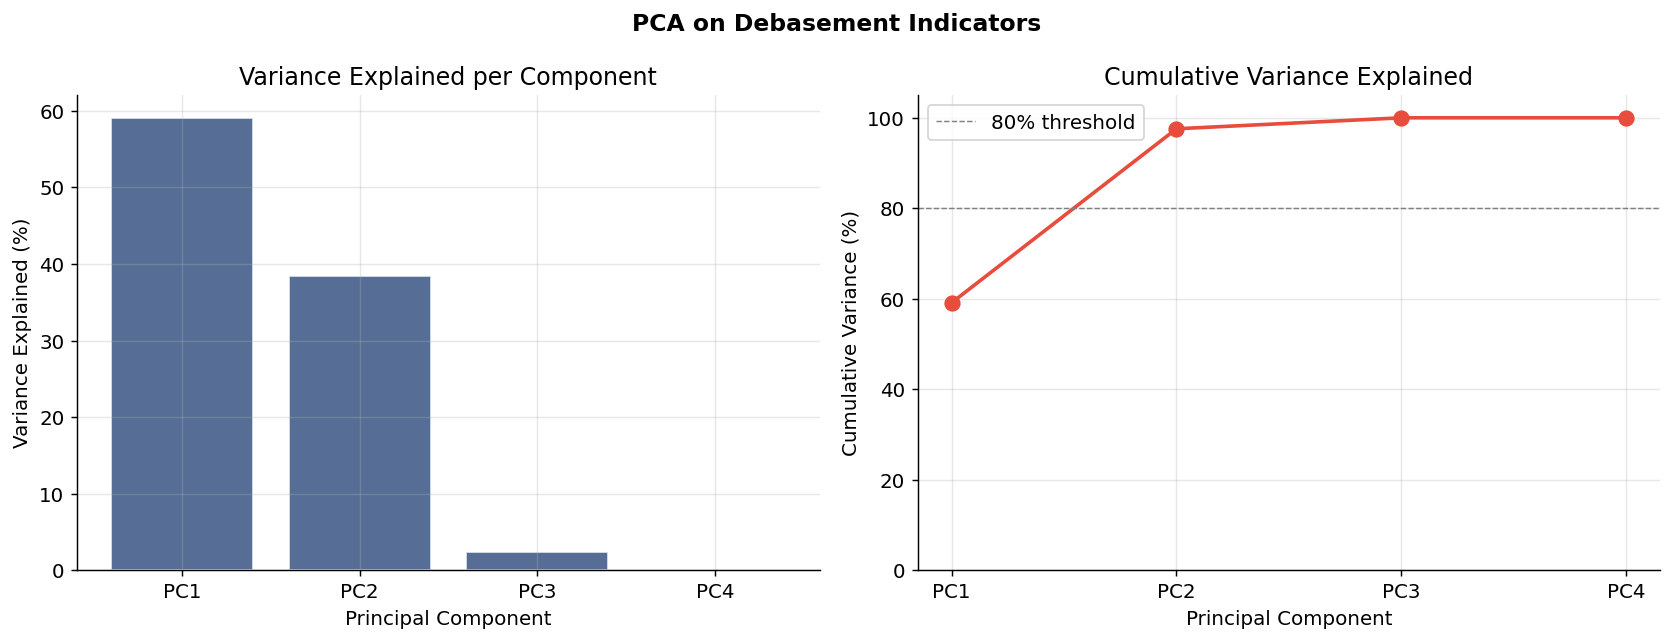

In [11]:
# Scree plot — variance explained per component
figure, axes = plt.subplots(1, 2, figsize=(13, 5))
figure.suptitle("PCA on Debasement Indicators", fontsize=13, fontweight="bold")

component_labels = [f"PC{i + 1}" for i in range(4)]

# Left: individual variance per component
axes[0].bar(component_labels, explained_variance_ratio * 100, color="#2C4A7C", alpha=0.8, edgecolor="white")
axes[0].set_title("Variance Explained per Component")
axes[0].set_ylabel("Variance Explained (%)")
axes[0].set_xlabel("Principal Component")

# Right: cumulative variance
axes[1].plot(component_labels, cumulative_variance * 100, marker="o", color="#E74C3C", linewidth=2, markersize=8)
axes[1].axhline(80, color="grey", linestyle="--", linewidth=0.8, label="80% threshold")
axes[1].set_title("Cumulative Variance Explained")
axes[1].set_ylabel("Cumulative Variance (%)")
axes[1].set_xlabel("Principal Component")
axes[1].set_ylim(0, 105)
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "pca_scree_plot.png"), bbox_inches="tight")
plt.show()

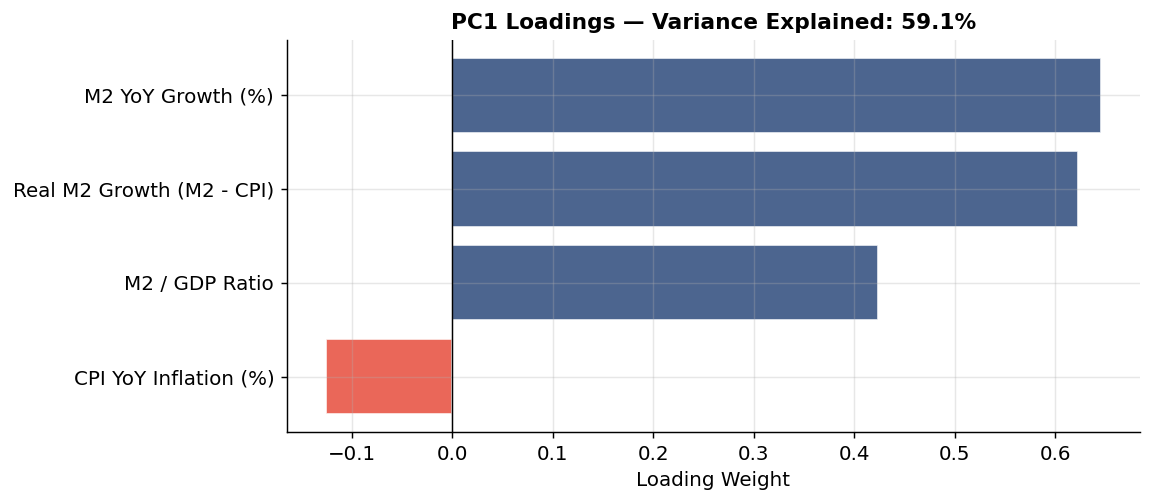

PC1 Loadings:
CPI YoY Inflation (%)       -0.1259
M2 / GDP Ratio               0.4239
Real M2 Growth (M2 - CPI)    0.6226
M2 YoY Growth (%)            0.6456


In [12]:
# PC1 loadings — which indicators drive the first component most?
pc1_loadings = pd.Series(
    pca_model.components_[0],
    index=[DEBASEMENT_LABELS[col] for col in DEBASEMENT_INDICATOR_COLUMNS]
).sort_values()

figure, axis = plt.subplots(figsize=(9, 4))
colors = ["#E74C3C" if loading < 0 else "#2C4A7C" for loading in pc1_loadings]
axis.barh(pc1_loadings.index, pc1_loadings.values, color=colors, alpha=0.85, edgecolor="white")
axis.axvline(0, color="black", linewidth=0.8)
axis.set_title(f"PC1 Loadings — Variance Explained: {explained_variance_ratio[0] * 100:.1f}%",
               fontsize=12, fontweight="bold")
axis.set_xlabel("Loading Weight")

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "pca_pc1_loadings.png"), bbox_inches="tight")
plt.show()

print("PC1 Loadings:")
print(pc1_loadings.round(4).to_string())

## 9. PCA Score vs Z-Score Composite — Comparison

The key validation check: do both methods tell the same story? High correlation = equal-weighting assumption in z-score composite is reasonable.

In [13]:
# Derive PCA debasement score (PC1 projection)
pca_scores = pca_model.transform(debasement_matrix_standardized)
pca_debasement_score = pd.Series(pca_scores[:, 0], index=analysis_df.index, name="pca_debasement_score")

# Align sign: PCA sign is arbitrary — flip if anti-correlated with z-score composite
zscore_composite = analysis_df["zscore_composite_debasement_score"]
if pca_debasement_score.corr(zscore_composite) < 0:
    pca_debasement_score = -pca_debasement_score
    print("PC1 sign flipped to align with z-score composite direction")

correlation_between_scores = pca_debasement_score.corr(zscore_composite)
print(f"Correlation between PCA score and Z-score composite: {correlation_between_scores:.4f}")

Correlation between PCA score and Z-score composite: 0.8658


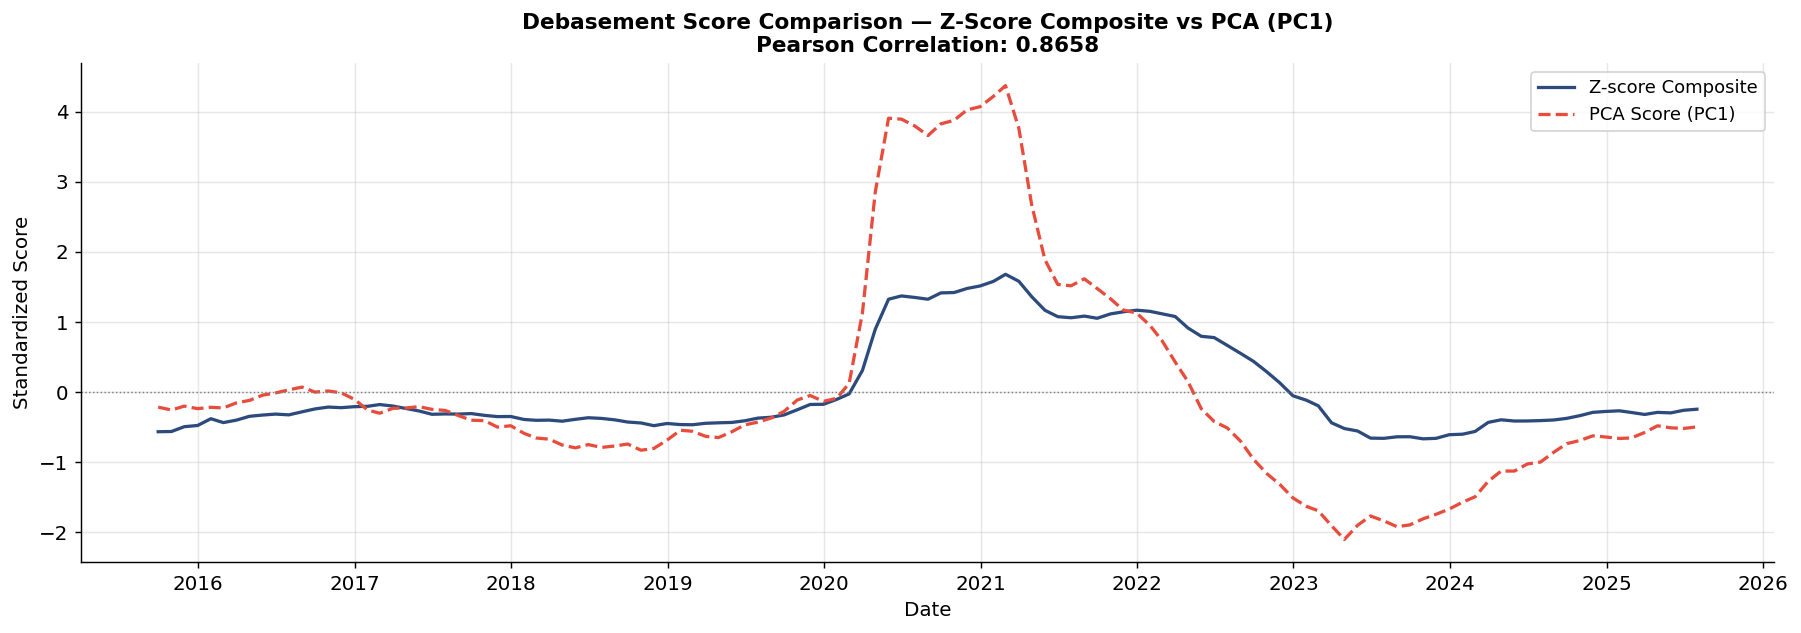

In [14]:
# Time series comparison
figure, axis = plt.subplots(figsize=(14, 5))

axis.plot(analysis_df.index, zscore_composite,    label="Z-score Composite", color="#2C4A7C", linewidth=1.8)
axis.plot(analysis_df.index, pca_debasement_score, label="PCA Score (PC1)",  color="#E74C3C", linewidth=1.8, linestyle="--")
axis.axhline(0, color="grey", linestyle=":", linewidth=0.8)
axis.set_title(
    f"Debasement Score Comparison — Z-Score Composite vs PCA (PC1)\n"
    f"Pearson Correlation: {correlation_between_scores:.4f}",
    fontsize=12, fontweight="bold"
)
axis.set_ylabel("Standardized Score")
axis.set_xlabel("Date")
axis.legend(fontsize=10)
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "debasement_score_comparison_timeseries.png"), bbox_inches="tight")
plt.show()

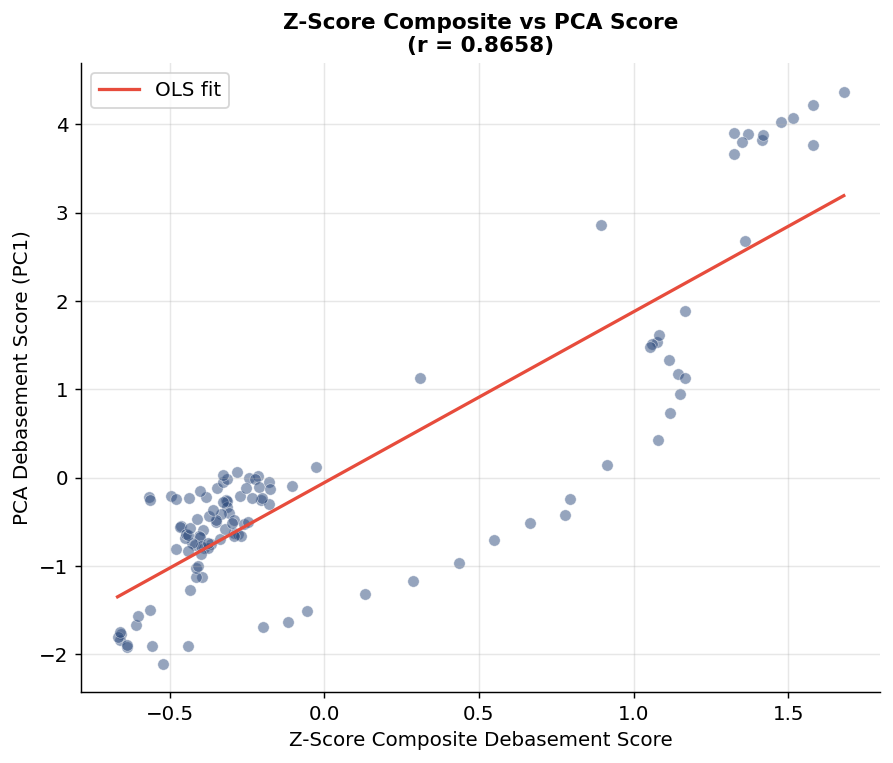

In [15]:
# Scatter plot comparison
figure, axis = plt.subplots(figsize=(7, 6))

axis.scatter(
    zscore_composite,
    pca_debasement_score,
    alpha=0.5,
    color="#2C4A7C",
    edgecolors="white",
    linewidth=0.4,
    s=40
)

# Fit and plot regression line
regression_coefficients = np.polyfit(zscore_composite, pca_debasement_score, deg=1)
regression_line_x = np.linspace(zscore_composite.min(), zscore_composite.max(), 200)
regression_line_y = np.polyval(regression_coefficients, regression_line_x)
axis.plot(regression_line_x, regression_line_y, color="#E74C3C", linewidth=1.8, label="OLS fit")

axis.set_title(
    f"Z-Score Composite vs PCA Score\n(r = {correlation_between_scores:.4f})",
    fontsize=12, fontweight="bold"
)
axis.set_xlabel("Z-Score Composite Debasement Score")
axis.set_ylabel("PCA Debasement Score (PC1)")
axis.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "debasement_score_comparison_scatter.png"), bbox_inches="tight")
plt.show()

## 10. Where Do the Two Scores Diverge?

Identify the periods where PCA and z-score composite disagree most — these are the interesting stress-test months.

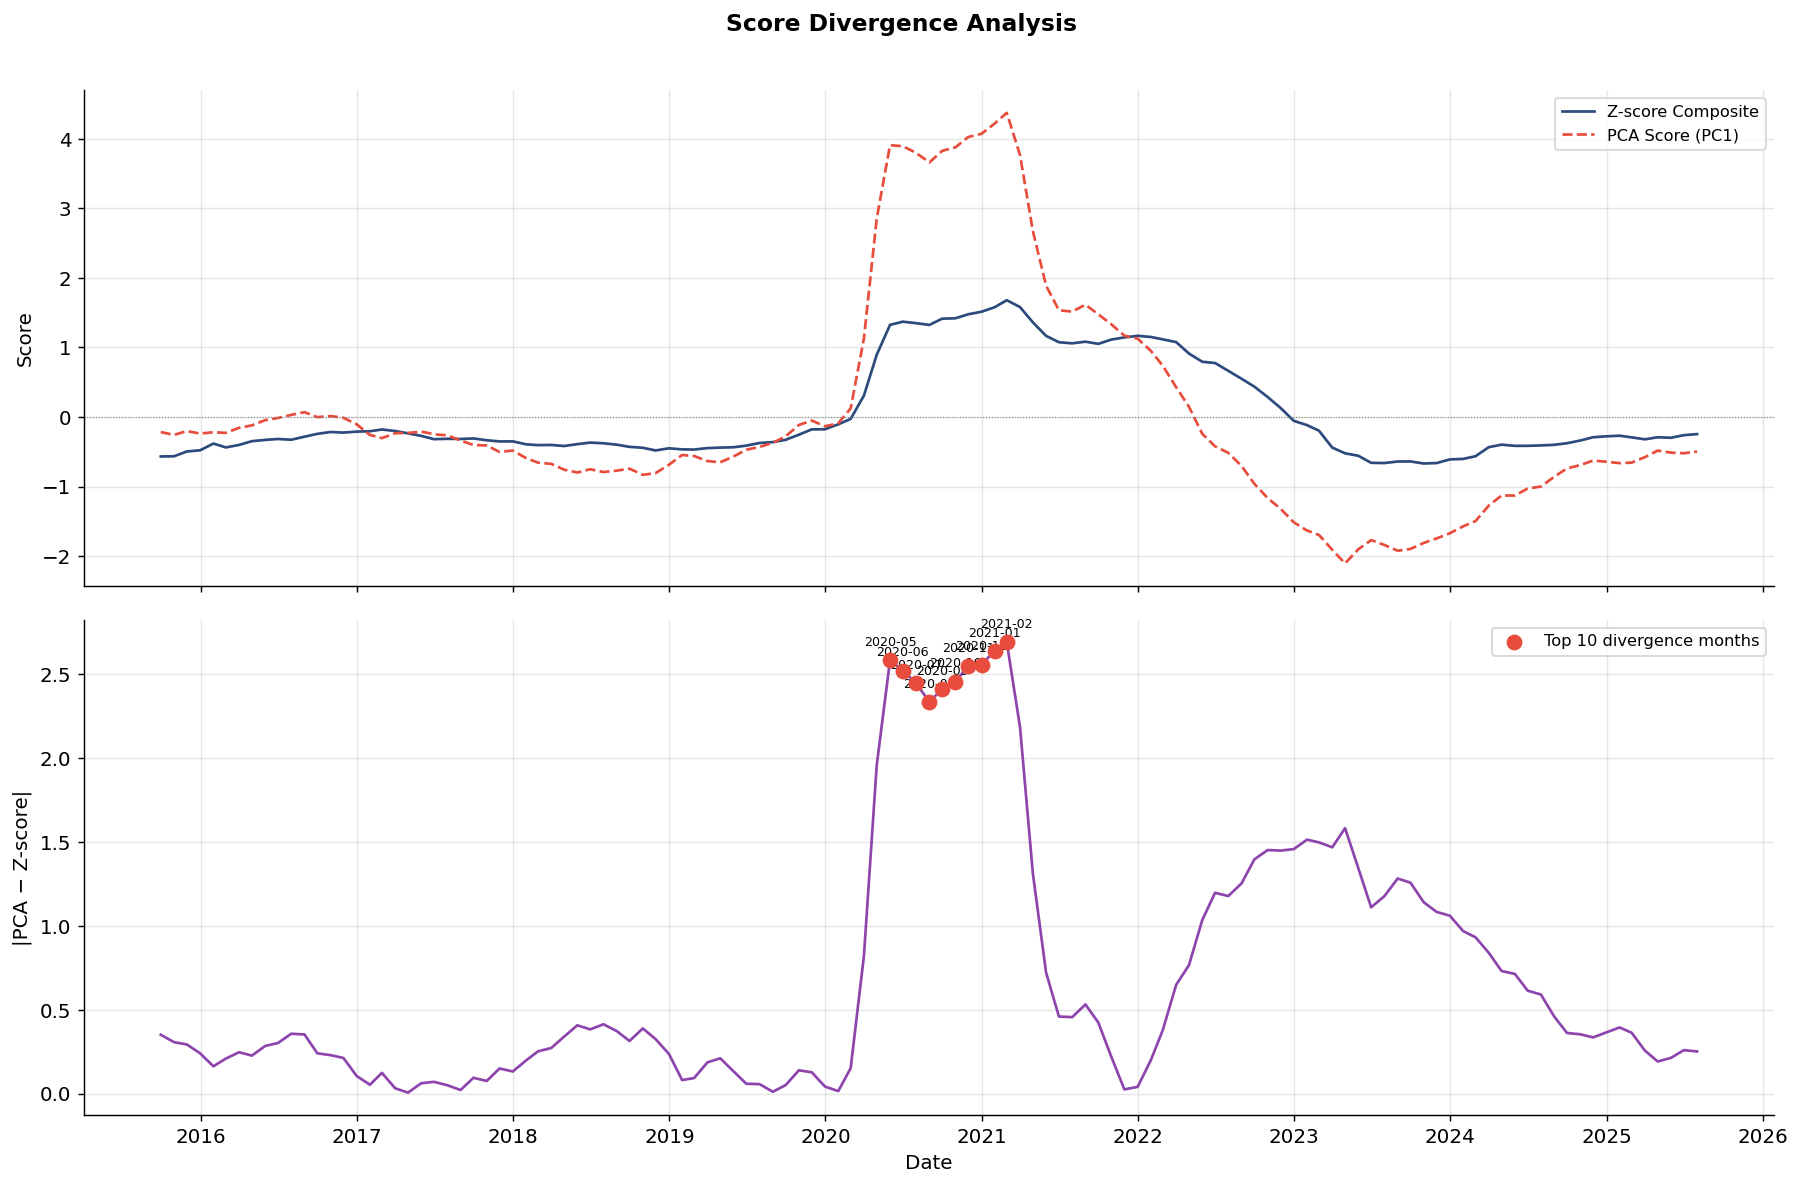


Top 10 months of score divergence:
            zscore_composite  pca_score  absolute_divergence
date                                                        
2021-02-28            1.6794     4.3719               2.6925
2021-01-31            1.5791     4.2202               2.6410
2020-05-31            1.3241     3.9069               2.5828
2020-12-31            1.5138     4.0718               2.5580
2020-11-30            1.4769     4.0254               2.5485
2020-06-30            1.3708     3.8934               2.5227
2020-10-31            1.4195     3.8769               2.4574
2020-07-31            1.3493     3.7968               2.4476
2020-09-30            1.4140     3.8263               2.4124
2020-08-31            1.3239     3.6596               2.3357


In [16]:
# Divergence = absolute difference between the two standardized scores
score_divergence = (pca_debasement_score - zscore_composite).abs()
score_divergence.name = "score_divergence"

# Top 10 months of maximum divergence
top_divergence_months = score_divergence.nlargest(10)

figure, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=True)
figure.suptitle("Score Divergence Analysis", fontsize=13, fontweight="bold", y=1.01)

# Top panel: both scores overlaid
axes[0].plot(analysis_df.index, zscore_composite,     label="Z-score Composite", color="#2C4A7C", linewidth=1.5)
axes[0].plot(analysis_df.index, pca_debasement_score, label="PCA Score (PC1)",   color="#E74C3C", linewidth=1.5, linestyle="--")
axes[0].axhline(0, color="grey", linestyle=":", linewidth=0.6)
axes[0].legend(fontsize=9)
axes[0].set_ylabel("Score")

# Bottom panel: divergence with top months highlighted
axes[1].plot(analysis_df.index, score_divergence, color="#8E44AD", linewidth=1.5)
axes[1].scatter(
    top_divergence_months.index,
    top_divergence_months.values,
    color="#E74C3C",
    zorder=5,
    s=60,
    label="Top 10 divergence months"
)
for divergence_date, divergence_value in top_divergence_months.items():
    axes[1].annotate(
        divergence_date.strftime("%Y-%m"),
        xy=(divergence_date, divergence_value),
        xytext=(0, 8),
        textcoords="offset points",
        fontsize=7,
        ha="center"
    )
axes[1].set_ylabel("|PCA − Z-score|")
axes[1].set_xlabel("Date")
axes[1].legend(fontsize=9)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "score_divergence_analysis.png"), bbox_inches="tight")
plt.show()

print("\nTop 10 months of score divergence:")
divergence_summary_df = pd.DataFrame({
    "zscore_composite":    zscore_composite[top_divergence_months.index],
    "pca_score":           pca_debasement_score[top_divergence_months.index],
    "absolute_divergence": top_divergence_months
})
print(divergence_summary_df.round(4).to_string())

## 11. Summary — Which Score to Use?

Decision framework based on the PCA results above.

In [17]:
pc1_variance_explained = explained_variance_ratio[0]

print("=" * 60)
print("DEBASEMENT SCORE SELECTION SUMMARY")
print("=" * 60)
print(f"PC1 variance explained:           {pc1_variance_explained * 100:.1f}%")
print(f"Correlation (PCA vs z-score):     {correlation_between_scores:.4f}")
print()

if pc1_variance_explained >= 0.65 and correlation_between_scores >= 0.90:
    print("Conclusion: HIGH alignment between methods.")
    print("Z-score composite is validated — use it for the analysis.")
    print("Equal-weighting assumption holds well in this sample.")
elif pc1_variance_explained >= 0.65 and correlation_between_scores < 0.90:
    print("Conclusion: PCA captures shared variance well but diverges from z-score.")
    print("Prefer PCA score — it reflects the data-driven weighting more faithfully.")
    print("Investigate divergence periods for structural breaks.")
else:
    print("Conclusion: PC1 explains limited variance — indicators are weakly correlated.")
    print("Debasement is multi-dimensional in this sample.")
    print("Consider using individual indicators separately rather than a composite.")

print()
print("PC1 Dominant Indicators (by absolute loading):")
for indicator, loading in pc1_loadings.abs().sort_values(ascending=False).items():
    print(f"  {indicator}: {loading:.4f}")

DEBASEMENT SCORE SELECTION SUMMARY
PC1 variance explained:           59.1%
Correlation (PCA vs z-score):     0.8658

Conclusion: PC1 explains limited variance — indicators are weakly correlated.
Debasement is multi-dimensional in this sample.
Consider using individual indicators separately rather than a composite.

PC1 Dominant Indicators (by absolute loading):
  M2 YoY Growth (%): 0.6456
  Real M2 Growth (M2 - CPI): 0.6226
  M2 / GDP Ratio: 0.4239
  CPI YoY Inflation (%): 0.1259
